In [1]:
!pip install pytelegrambotapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 8.8 MB/s 
  Created wheel for pytelegrambotapi: filename=pyTelegramBotAPI-4.5.1-py3-none-any.whl size=138116 sha256=920fba0e9b6451d6aec18877004813fe8856f5c9ce662740156da2c414fde29f
  Stored in directory: /root/.cache/pip/wheels/9a/90/69/89e4e68c819633d933753827fd4f3a22987e162b7404b092b5
Successfully built pytelegrambotapi


In [2]:
import telebot

In [33]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import PIL.Image
import time
import functools

from telebot.types import InputMediaPhoto

In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [5]:
def tensor_to_image(tensor, uid):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]

  result = PIL.Image.fromarray(tensor)
  result.save(str(uid) + 'result.jpg')

In [6]:
def preprocess_photo(photo, uid, postfix):
  fileID = photo.photo[-1].file_id
    
  file_info = bot.get_file(fileID)
   
  downloaded_file = bot.download_file(file_info.file_path)

  with open(str(uid) + postfix + ".jpg", 'wb') as new_file:
      new_file.write(downloaded_file)
  return open(str(uid) + postfix + ".jpg", 'rb') #cv2.imread("image.jpg") #open("image.jpg", 'rb') #downloaded_file

In [9]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [ ]:
#content = load_img('radmir.jpg')
#style = load_img('style4.jpg')

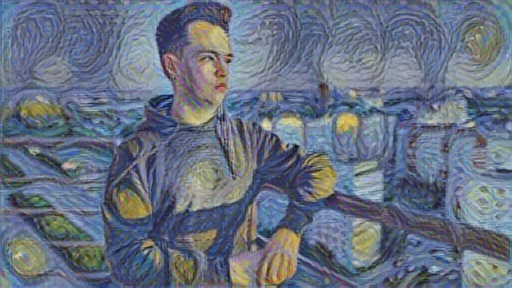

In [ ]:
#stylized_image = hub_model(tf.constant(content), tf.constant(style))[0]
#tensor_to_image(stylized_image)

In [37]:
def check_user_status(d, uid, v=None):
  if v is not None:
    d[uid] = v
    return
  if uid not in d.keys():
    d[uid] = 0
    return

def style_transfer(uid):
  content = load_img(str(uid) + 'content.jpg')
  style = load_img(str(uid) + 'style.jpg')
  stylized_image = hub_model(tf.constant(content), tf.constant(style))[0]
  tensor_to_image(stylized_image, uid)

In [44]:
def get_styles():
  st1 = open('styles/1.jpg', 'rb')
  st2 = open('styles/2.jpg', 'rb')
  st3 = open('styles/3.jpg', 'rb')
  st4 = open('styles/4.jpg', 'rb')
  st5 = open('styles/5.jpg', 'rb')
  st6 = open('styles/6.jpg', 'rb')
  st7 = open('styles/7.jpg', 'rb')

  return [InputMediaPhoto(st1), InputMediaPhoto(st2), InputMediaPhoto(st3), InputMediaPhoto(st4), InputMediaPhoto(st5), InputMediaPhoto(st6), InputMediaPhoto(st7)]

In [45]:
bot = telebot.TeleBot('<token>')

users = dict()

@bot.message_handler(commands=['start'])
def start_message(message):
  user_id = message.from_user.id
  check_user_status(users, user_id, 0)
  bot.send_message(message.chat.id, 'Привет! Тут можно делать style transfer для изображений. \nНапиши /help, если ты не знаешь как со мной работать.')


@bot.message_handler(commands=['help'])
def start_message(message):
  user_id = message.from_user.id
  check_user_status(users, user_id, 0)
  bot.send_message(message.chat.id, 'Отправь мне две фотографии по очереди: \n1 - Изображение контента\n2 - Изображение стиля\nЯ выдам тебе результат - наложу стиль с изображения 2 на контент изображения 1\nПо команде /styles я могу отправить тебе примеры стилей для изображений :)')


@bot.message_handler(commands=['styles'])
def start_message(message):
  user_id = message.from_user.id
  check_user_status(users, user_id, 0)
  media = get_styles()
  bot.send_media_group(message.chat.id, media)


@bot.message_handler(content_types=['photo'])
def send_photo(photo):
  user_id = photo.from_user.id
  check_user_status(users, user_id)

  if users[user_id] == 1:
    message = 'Лови результат!'
    users[user_id] = 0
    img = preprocess_photo(photo, user_id, 'style')
    style_transfer(user_id)
    bot.send_message(photo.chat.id, message)
    bot.send_photo(photo.chat.id, open(str(user_id) + "result.jpg", 'rb'))

  elif users[user_id] == 0:
    message = 'Круто! Теперь отправь изображение стиля'
    users[user_id] = 1
    img = preprocess_photo(photo, user_id, 'content')
    bot.send_message(photo.chat.id, message)


bot.polling()